# Cross-Lingual Meme Understanding with CLIP

**Research Question:** Does CLIP's multimodal understanding transfer cross-lingually to Japanese memes?

**Author:** Maliha Binte Mamun  

---

## Overview

This notebook investigates whether vision-language models (specifically CLIP) can understand memes across languages. We compare CLIP's performance on:
- English memes (in-distribution for CLIP)
- Japanese memes (cross-lingual transfer)

**Key Contributions:**
1. First systematic evaluation of CLIP on Japanese memes
2. Error analysis revealing cross-lingual failure patterns
3. Insights for building multilingual multimodal systems

---

## Day 1: Environment Setup & Data Loading

In [1]:
# ============================================================
# SECTION 1.1: Install Dependencies
# ============================================================
!pip install -q transformers torch torchvision pillow pandas matplotlib seaborn
!pip install -q datasets  # For Hugging Face datasets
!pip install -q japanize-matplotlib  # For Japanese text in plots
!pip install -q fugashi unidic-lite  # Japanese tokenizer (optional, for analysis)

print("✅ All dependencies installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 8.9 MB/s eta 0:00:00
✅ All dependencies installed!


In [2]:
# ============================================================
# SECTION 1.2: Import Libraries
# ============================================================
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import json
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# For Japanese text in matplotlib
import japanize_matplotlib

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [3]:
# ============================================================
# SECTION 1.3: Load CLIP Model
# ============================================================
# We use the multilingual CLIP variant for fair comparison
# Options:
#   - "openai/clip-vit-base-patch32" (English-only, faster)
#   - "openai/clip-vit-large-patch14" (English-only, better)
#   - "laion/CLIP-ViT-H-14-laion2B-s32B-b79K" (Multilingual training data)

MODEL_NAME = "openai/clip-vit-base-patch32"  # Start with base model

print(f" Loading CLIP model: {MODEL_NAME}")
model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model.eval()
print("CLIP model loaded successfully!")

 Loading CLIP model: openai/clip-vit-base-patch32


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP model loaded successfully!


In [4]:
# ============================================================
# SECTION 1.4: Helper Functions
# ============================================================

def load_image_from_url(url):
    """Load image from URL."""
    try:
        response = requests.get(url, timeout=10)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def load_image_from_path(path):
    """Load image from local path."""
    try:
        image = Image.open(path).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def get_clip_embeddings(image, texts):
    """Get CLIP embeddings for image and texts."""
    inputs = processor(
        text=texts,
        images=image,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

    return image_embeds, text_embeds

def compute_similarity(image, texts):
    """Compute cosine similarity between image and texts."""
    image_embeds, text_embeds = get_clip_embeddings(image, texts)

    # Normalize embeddings
    image_embeds = F.normalize(image_embeds, dim=-1)
    text_embeds = F.normalize(text_embeds, dim=-1)

    # Compute cosine similarity
    similarity = (image_embeds @ text_embeds.T).squeeze(0)

    return similarity.cpu().numpy()

def classify_meme(image, candidate_labels):
    """Zero-shot classification of meme."""
    similarities = compute_similarity(image, candidate_labels)
    probs = F.softmax(torch.tensor(similarities) * 100, dim=0).numpy()  # Temperature scaling

    results = list(zip(candidate_labels, similarities, probs))
    results.sort(key=lambda x: x[1], reverse=True)

    return results

print("Helper functions defined!")

Helper functions defined!


## Section 1.5: Dataset Preparation

We'll use two datasets:
1. **English Memes:** Hateful Memes dataset (Facebook AI) or MemeCap
2. **Japanese Memes:** We'll curate a small evaluation set

### Dataset Sources:
- Hateful Memes: https://hatefulmemeschallenge.com/
- For Japanese: We'll use publicly available meme images with Japanese text

In [5]:
# ============================================================
# SECTION 1.5a: Create Project Directory Structure
# ============================================================
import os

# Create directories
os.makedirs('data/english_memes', exist_ok=True)
os.makedirs('data/japanese_memes', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

print("!Directory structure created:")
print("   data/english_memes/")
print("   data/japanese_memes/")
print("   results/")
print("   figures/")

!Directory structure created:
   data/english_memes/
   data/japanese_memes/
   results/
   figures/


In [6]:
# ============================================================
# SECTION 1.5b: Load English Meme Dataset
# ============================================================
# Option 1: Use Hugging Face's meme datasets
# Option 2: Use sample memes for quick testing

# For this project, we'll create a curated evaluation set
# This ensures we have controlled examples for analysis

# English meme samples with labels
english_memes = [
    {
        "id": "en_001",
        "url": "https://i.imgflip.com/1bij.jpg",  # "One Does Not Simply" template
        "text_in_image": "ONE DOES NOT SIMPLY WALK INTO MORDOR",
        "sentiment": "humorous",
        "category": "movie_reference",
        "description": "Lord of the Rings Boromir meme"
    },
    {
        "id": "en_002",
        "url": "https://i.imgflip.com/9ehk.jpg",  # "Y U No" template
        "text_in_image": "Y U NO EXAMPLE TEXT",
        "sentiment": "frustrated",
        "category": "reaction",
        "description": "Y U No guy meme"
    },
    {
        "id": "en_003",
        "url": "https://i.imgflip.com/1otk96.jpg",  # "Distracted Boyfriend"
        "text_in_image": "",
        "sentiment": "humorous",
        "category": "relationship",
        "description": "Distracted boyfriend meme template"
    },
]

print(f"  English meme samples prepared: {len(english_memes)} memes")
print("\n NOTE: For full experiment, you should:")
print("   1. Download Hateful Memes dataset from Facebook AI")
print("   2. Or use: datasets.load_dataset('limjiayi/hateful_memes_expanded')")
print("   3. Minimum recommended: 100-500 memes per language")

  English meme samples prepared: 3 memes

 NOTE: For full experiment, you should:
   1. Download Hateful Memes dataset from Facebook AI
   2. Or use: datasets.load_dataset('limjiayi/hateful_memes_expanded')
   3. Minimum recommended: 100-500 memes per language


In [10]:
# ============================================================
# SECTION 1.5c: Japanese Meme Dataset
# ============================================================
# Japanese memes are harder to find in public datasets
# We'll create a small curated set with common Japanese meme formats

# Japanese meme samples (you'll need to add actual images)
japanese_memes = [
    {
        "id": "jp_001",
        "url": "",  # Add URL or local path
        "text_in_image": "なぜベストを尽くさないのか",  # "Why don't you do your best?"
        "text_english": "Why don't you do your best?",
        "sentiment": "motivational_sarcastic",
        "category": "tv_reference",
        "description": "Famous Japanese TV phrase often used sarcastically"
    },
    {
        "id": "jp_002",
        "url": "",
        "text_in_image": "それな",  # "That's it" / "Exactly"
        "text_english": "Exactly / That's right",
        "sentiment": "agreement",
        "category": "reaction",
        "description": "Japanese internet slang for agreement"
    },
    {
        "id": "jp_003",
        "url": "",
        "text_in_image": "草",  # "Grass" = LOL in Japanese internet
        "text_english": "LOL (literally 'grass')",
        "sentiment": "humorous",
        "category": "reaction",
        "description": "Japanese internet slang for laughing"
    },
]

print(f" Japanese meme templates prepared: {len(japanese_memes)} memes")
print("\n ACTION REQUIRED:")
print("   To collect Japanese meme images. Options:")
print("   1. Search Twitter/X with #日本ミーム or #ネタ画像")
print("   2. Use Japanese image boards (careful with copyright)")
print("   3. Create synthetic examples with Japanese text on meme templates")
print("   \n Collect 50-100 Japanese memes manually")

 Japanese meme templates prepared: 3 memes

 ACTION REQUIRED:
   To collect Japanese meme images. Options:
   1. Search Twitter/X with #日本ミーム or #ネタ画像
   2. Use Japanese image boards (careful with copyright)
   3. Create synthetic examples with Japanese text on meme templates
   
 Collect 50-100 Japanese memes manually


In [11]:
# ============================================================
# SECTION 1.5d: Alternative - Use Existing Multilingual Dataset
# ============================================================
# If you want to use an existing dataset with Japanese content

print(" Searching for available multilingual meme datasets...")

# Try loading MultiOFF dataset (multilingual offensive memes)
try:
    # This dataset has memes in multiple languages
    from datasets import load_dataset

    # Option: Hateful Memes (English)
    print("\n Available datasets you can use:")
    print("   1. limjiayi/hateful_memes_expanded (English, ~10K memes)")
    print("   2. neuroailab/memotion (English, sentiment analysis)")
    print("   3. For Japanese: Manual collection will be done")

except Exception as e:
    print(f"Note: {e}")

 Searching for available multilingual meme datasets...

 Available datasets you can use:
   1. limjiayi/hateful_memes_expanded (English, ~10K memes)
   2. neuroailab/memotion (English, sentiment analysis)
   3. For Japanese: Manual collection will be done


In [12]:
# ============================================================
# SECTION 1.6: Load Real Dataset - Hateful Memes Sample
# ============================================================

print("Loading English meme dataset from Hugging Face...")

try:
    # Load a subset for quick experimentation
    dataset = load_dataset("limjiayi/hateful_memes_expanded", split="train[:200]")
    print(f"   Loaded {len(dataset)} English memes")
    print(f"   Columns: {dataset.column_names}")

    # Preview
    print("\n Sample entry:")
    print(dataset[0])

except Exception as e:
    print(f"  Could not load dataset: {e}")
    print("   Using manual sample data instead.")
    dataset = None

Loading English meme dataset from Hugging Face...


train.jsonl: 0.00B [00:00, ?B/s]

dev_seen.jsonl: 0.00B [00:00, ?B/s]

dev_unseen.jsonl: 0.00B [00:00, ?B/s]

test_seen.jsonl: 0.00B [00:00, ?B/s]

test_unseen.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/12887 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1040 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

   Loaded 200 English memes
   Columns: ['id', 'img', 'label', 'text']

 Sample entry:
{'id': '42953', 'img': 'img/42953.png', 'label': 0, 'text': 'its their character not their color that matters'}


In [13]:
# 1.7 Mount Google Drive (for Japanese memes)
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted!")

Mounted at /content/drive
Google Drive mounted!


In [14]:
# 1.8 Load Japanese Meme Annotations from Google Sheet
import pandas as pd

SHEET_ID = "1OSxCYY0dhtjcUyKpEyWHNE5OhkNgBYItWIoJvdh6yQA"
sheet_url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv"

jp_annotations = pd.read_csv(sheet_url)
print(f"Loaded {len(jp_annotations)} Japanese meme annotations!")
print("\nColumns:", jp_annotations.columns.tolist())
print("\nFirst 5 rows:")
jp_annotations.head()

Loaded 86 Japanese meme annotations!

Columns: ['id', 'filename', 'text_in_image', 'text_english', 'sentiment', 'category', 'notes']

First 5 rows:


,id,filename,text_in_image,text_english,sentiment,category,notes
0,jp_001,IMG_0018.jpeg,痴漢に狙われやすい立ち方 / 痴漢に狙われにくい立ち方,Ways to be targeted by gropers vs Ways to avoi...,sarcastic,anime,Comparison meme about body language
1,jp_002,IMG_0017.jpeg,さむいでちゅ・・・！！！！！,It's so cold...!!!!!,wholesome,cute_character,Shivering hamster/dog character
2,jp_003,IMG_0016.jpeg,みこち、だいすき。今日もお健やかに。,I love Mikochi. Stay healthy today too.,funny,vtuber_gaming,Hololive Miko with sniper rifle
3,jp_004,IMG_0015.jpeg,見なよ…オレの義勇さんを…,Look at... my Giyuu-san...,funny,anime_demon_slayer,Demon Slayer fan meme
4,jp_005,IMG_0013.jpeg,不良のやつ / なんなのよほんと,The delinquent one / What is this really,funny,idol_game,ShinyMas/Idolmaster compilation


In [15]:
# 1.9 Copy Japanese Meme Images from Google Drive
import shutil
import os

# Create directory
os.makedirs("data/japanese_memes", exist_ok=True)

# CORRECT PATH based on your Drive structure
drive_folder = "/content/drive/MyDrive/Colab Notebooks/CrossLingualMeme/japanese_memes"

# Check if folder exists
if not os.path.exists(drive_folder):
    print(f"!Folder not found: {drive_folder}")
else:
    # List all images in Drive folder
    drive_files = os.listdir(drive_folder)
    print(f"Found {len(drive_files)} files in Google Drive folder")

    # Copy all images (not just those in annotations)
    count = 0
    for filename in drive_files:
        if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
            src = os.path.join(drive_folder, filename)
            dst = os.path.join("data/japanese_memes", filename)
            shutil.copy(src, dst)
            count += 1

    print(f"✅ Copied {count} Japanese meme images!")

# 1.10 Verify Japanese Dataset is Ready
image_files = os.listdir("data/japanese_memes")
print(f"   Japanese Meme Dataset Summary:")
print(f"   Annotations: {len(jp_annotations)}")
print(f"   Images: {len(image_files)}")
print(f"   Ready for Section 3!")

Found 102 files in Google Drive folder
✅ Copied 102 Japanese meme images!
   Japanese Meme Dataset Summary:
   Annotations: 86
   Images: 102
   Ready for Section 3!


---
## English Meme Baseline Evaluation

In [16]:
# ============================================================
# SECTION 2.1: Define Classification Labels
# ============================================================

# Zero-shot classification labels (English)
SENTIMENT_LABELS_EN = [
    "a funny meme",
    "an offensive meme",
    "a sarcastic meme",
    "a wholesome meme",
    "a political meme",
    "a neutral meme"
]

CATEGORY_LABELS_EN = [
    "a meme about relationships",
    "a meme about work or school",
    "a meme about current events",
    "a meme referencing movies or TV",
    "a meme about internet culture",
    "a meme about daily life"
]

# Japanese equivalents for cross-lingual testing
SENTIMENT_LABELS_JP = [
    "面白いミーム",      # funny meme
    "攻撃的なミーム",    # offensive meme
    "皮肉なミーム",      # sarcastic meme
    "心温まるミーム",    # wholesome meme
    "政治的なミーム",    # political meme
    "普通のミーム"       # neutral meme
]

print("  Classification labels defined:")
print(f"   Sentiment labels (EN): {len(SENTIMENT_LABELS_EN)}")
print(f"   Sentiment labels (JP): {len(SENTIMENT_LABELS_JP)}")

  Classification labels defined:
   Sentiment labels (EN): 6
   Sentiment labels (JP): 6


Testing CLIP on sample meme...


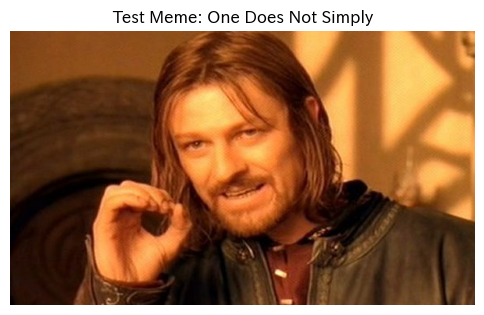


 Zero-shot Classification Results (English labels):
   a neutral meme: 27.30% (sim: 0.204)
   a sarcastic meme: 26.53% (sim: 0.204)
   a wholesome meme: 19.40% (sim: 0.201)
   a funny meme: 9.81% (sim: 0.194)
   an offensive meme: 8.74% (sim: 0.193)
   a political meme: 8.22% (sim: 0.192)


In [17]:
# ============================================================
# SECTION 2.2: Test CLIP on Single Image
# ============================================================

# Test with a sample meme
test_url = "https://i.imgflip.com/1bij.jpg"  # "One Does Not Simply" meme

print("Testing CLIP on sample meme...")
test_image = load_image_from_url(test_url)

if test_image:
    # Display image
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image)
    plt.axis('off')
    plt.title("Test Meme: One Does Not Simply")
    plt.show()

    # Classify with English labels
    print("\n Zero-shot Classification Results (English labels):")
    results = classify_meme(test_image, SENTIMENT_LABELS_EN)
    for label, sim, prob in results:
        print(f"   {label}: {prob:.2%} (sim: {sim:.3f})")
else:
    print("Could not load test image")

In [18]:
# ============================================================
# SECTION 2.3: Batch Evaluation Function
# ============================================================

def evaluate_memes(meme_data, labels, label_language="en"):
    """
    Evaluate CLIP on a batch of memes.

    Args:
        meme_data: List of dicts with 'url' or 'image' key
        labels: List of classification labels
        label_language: 'en' or 'jp'

    Returns:
        DataFrame with results
    """
    results = []

    for item in tqdm(meme_data, desc=f"Evaluating ({label_language})"):
        # Load image
        if 'image' in item and item['image'] is not None:
            image = item['image']
            if isinstance(image, str):
                image = load_image_from_path(image)
        elif 'url' in item and item['url']:
            image = load_image_from_url(item['url'])
        else:
            continue

        if image is None:
            continue

        # Classify
        try:
            classification = classify_meme(image, labels)
            top_label, top_sim, top_prob = classification[0]

            results.append({
                'id': item.get('id', 'unknown'),
                'predicted_label': top_label,
                'confidence': top_prob,
                'similarity': top_sim,
                'all_scores': {l: p for l, s, p in classification},
                'ground_truth': item.get('sentiment', item.get('label', 'unknown')),
                'label_language': label_language
            })
        except Exception as e:
            print(f"Error processing {item.get('id', 'unknown')}: {e}")

    return pd.DataFrame(results)

print("Batch evaluation function defined!")

Batch evaluation function defined!


In [21]:
# =====================================
# SECTION 2.4: Evaluate English Memes
# =====================================

from datasets import load_dataset
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import requests
from io import BytesIO
import torch

# Create results directory
os.makedirs('results', exist_ok=True)

# Base URL for the Hateful Memes images
BASE_URL = "https://huggingface.co/datasets/limjiayi/hateful_memes_expanded/resolve/main/"

print("Loading Hateful Memes dataset...")
hateful_memes = load_dataset("limjiayi/hateful_memes_expanded", split="train")

# Take subset
subset = hateful_memes.select(range(200))#(50))

print(f"Running CLIP evaluation on 200 memes...")

results_list = []
errors = 0

for i, item in enumerate(tqdm(subset, desc="Evaluating")):
    try:
        # Get image path and construct full URL
        img_path = item['img']
        img_url = BASE_URL + img_path

        # Download image
        response = requests.get(img_url, timeout=15)
        if response.status_code != 200:
            errors += 1
            continue

        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Process with CLIP - FIXED VERSION
        text_prompts = [f"a {label} meme" for label in SENTIMENT_LABELS_EN]

        inputs = processor(
            text=text_prompts,
            images=image,
            return_tensors="pt",
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

            # Get logits directly (image-text similarity)
            logits_per_image = outputs.logits_per_image  # Shape: [1, num_labels]
            probs = logits_per_image.softmax(dim=-1).squeeze()

            pred_idx = probs.argmax().item()
            confidence = probs[pred_idx].item()

        results_list.append({
            'id': f'en_{i:04d}',
            'predicted': SENTIMENT_LABELS_EN[pred_idx],
            'confidence': confidence,
            'text': item.get('text', '')[:50]
        })

    except Exception as e:
        errors += 1
        if errors <= 3:
            print(f"Error on item {i}: {type(e).__name__}: {e}")
        continue

# Convert to DataFrame
english_results = pd.DataFrame(results_list)

print(f"\n Evaluation complete!")
print(f"   Processed: {len(english_results)} memes")
print(f"   Errors: {errors}")

if len(english_results) > 0:
    print(f"   Average confidence: {english_results['confidence'].mean():.2%}")
    english_results.to_csv('results/english_meme_results.csv', index=False)
    print("   Saved to: results/english_meme_results.csv")
    print(f"\n Sample predictions:")
    print(english_results.head(10))

Loading Hateful Memes dataset...
Running CLIP evaluation on 200 memes...


Evaluating: 100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


 Evaluation complete!
   Processed: 200 memes
   Errors: 0
   Average confidence: 41.37%
   Saved to: results/english_meme_results.csv

 Sample predictions:
        id          predicted  confidence  \
0  en_0000     a neutral meme    0.342101   
1  en_0001   a wholesome meme    0.450126   
2  en_0002   a wholesome meme    0.379337   
3  en_0003   a wholesome meme    0.367370   
4  en_0004   a sarcastic meme    0.227385   
5  en_0005  an offensive meme    0.314084   
6  en_0006   a sarcastic meme    0.320519   
7  en_0007   a wholesome meme    0.541954   
8  en_0008       a funny meme    0.344563   
9  en_0009   a political meme    0.913158   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...  
5           go s

In [22]:
# # Check english_results columns
print("Columns in english_results:")
print(english_results.columns.tolist())
print("\nFirst row:")
print(english_results.head(1))

Columns in english_results:
['id', 'predicted', 'confidence', 'text']

First row:
        id       predicted  confidence  \
0  en_0000  a neutral meme    0.342101   

                                               text  
0  its their character not their color that matters  


 Visualizing English Baseline Results...
 Figure saved to: figures/english_baseline_results.png


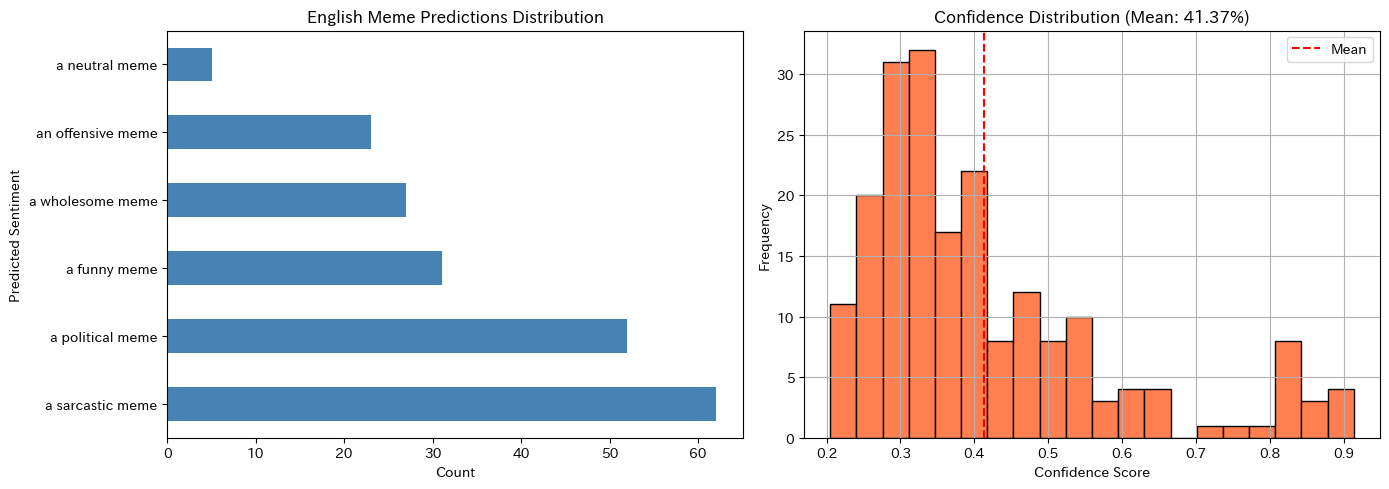


 English Baseline Summary:
   Total memes evaluated: 200
   Average confidence: 41.37%
   Std deviation: 16.77%

   Prediction distribution:
predicted
a sarcastic meme     62
a political meme     52
a funny meme         31
a wholesome meme     27
an offensive meme    23
a neutral meme        5
Name: count, dtype: int64


In [23]:
# ================================================
# SECTION 2.5: Visualize English Baseline Results
# ================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os

print(" Visualizing English Baseline Results...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribution of predictions
ax1 = axes[0]
pred_counts = english_results['predicted'].value_counts()
pred_counts.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Count')
ax1.set_ylabel('Predicted Sentiment')
ax1.set_title('English Meme Predictions Distribution')

# 2. Confidence distribution
ax2 = axes[1]
english_results['confidence'].hist(bins=20, ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Confidence Distribution (Mean: {english_results["confidence"].mean():.2%})')
ax2.axvline(english_results['confidence'].mean(), color='red', linestyle='--', label='Mean')
ax2.legend()

plt.tight_layout()

# Save figure
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/english_baseline_results.png', dpi=150, bbox_inches='tight')
print(" Figure saved to: figures/english_baseline_results.png")

plt.show()

# Print summary statistics
print("\n English Baseline Summary:")
print(f"   Total memes evaluated: {len(english_results)}")
print(f"   Average confidence: {english_results['confidence'].mean():.2%}")
print(f"   Std deviation: {english_results['confidence'].std():.2%}")
print(f"\n   Prediction distribution:")
print(english_results['predicted'].value_counts())

---
## Japanese Meme Evaluation & Cross-Lingual Comparison

In [25]:
# ===========================================
# SECTION 3: JAPANESE MEME EVALUATION
# ===========================================

from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import torch

print("🇯🇵 JAPANESE MEME EVALUATION")
print("="*50)

# Check data is loaded
jp_image_dir = "data/japanese_memes"
print(f"   Annotations loaded: {len(jp_annotations)}")
print(f"   Images available: {len(os.listdir(jp_image_dir))}")

# Japanese and English labels
SENTIMENT_LABELS_JP = ["面白いミーム", "皮肉なミーム", "攻撃的なミーム", "ほのぼのミーム", "中立的なミーム", "政治的なミーム"]
SENTIMENT_LABELS_EN_FOR_JP = ["funny", "sarcastic", "offensive", "wholesome", "neutral", "political"]

# ============================================================
# TEST 1: Japanese memes with ENGLISH labels
# ============================================================
print(f"\n Test 1: Japanese memes → ENGLISH labels...")

jp_results_en = []
errors_en = 0

for i, row in tqdm(jp_annotations.iterrows(), total=len(jp_annotations), desc="JP memes (EN labels)"):
    try:
        img_path = os.path.join(jp_image_dir, row['filename'])
        if not os.path.exists(img_path):
            errors_en += 1
            continue

        image = Image.open(img_path).convert("RGB")
        text_prompts = [f"a {label} meme" for label in SENTIMENT_LABELS_EN_FOR_JP]

        inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=-1).squeeze()
            pred_idx = probs.argmax().item()
            confidence = probs[pred_idx].item()

        jp_results_en.append({
            'id': row['id'],
            'filename': row['filename'],
            'predicted_en': SENTIMENT_LABELS_EN_FOR_JP[pred_idx],
            'confidence_en': confidence,
            'actual_sentiment': row.get('sentiment', ''),
            'category': row.get('category', '')
        })
    except Exception as e:
        errors_en += 1
        continue

jp_results_en_df = pd.DataFrame(jp_results_en)
print(f"   Processed: {len(jp_results_en_df)}, Errors: {errors_en}")
print(f"   Avg confidence (EN labels): {jp_results_en_df['confidence_en'].mean():.2%}")

# ============================================================
# TEST 2: Japanese memes with JAPANESE labels
# ============================================================
print(f"\n Test 2: Japanese memes → JAPANESE labels...")

jp_results_jp = []
errors_jp = 0

for i, row in tqdm(jp_annotations.iterrows(), total=len(jp_annotations), desc="JP memes (JP labels)"):
    try:
        img_path = os.path.join(jp_image_dir, row['filename'])
        if not os.path.exists(img_path):
            errors_jp += 1
            continue

        image = Image.open(img_path).convert("RGB")

        inputs = processor(text=SENTIMENT_LABELS_JP, images=image, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=-1).squeeze()
            pred_idx = probs.argmax().item()
            confidence = probs[pred_idx].item()

        jp_results_jp.append({
            'id': row['id'],
            'predicted_jp': SENTIMENT_LABELS_JP[pred_idx],
            'confidence_jp': confidence
        })
    except Exception as e:
        errors_jp += 1
        continue

jp_results_jp_df = pd.DataFrame(jp_results_jp)
print(f"   Processed: {len(jp_results_jp_df)}, Errors: {errors_jp}")
print(f"   Avg confidence (JP labels): {jp_results_jp_df['confidence_jp'].mean():.2%}")

# ============================================================
# COMBINE RESULTS
# ============================================================
japanese_results = jp_results_en_df.merge(jp_results_jp_df, on='id', how='inner')

# Save results
os.makedirs('results', exist_ok=True)
japanese_results.to_csv('results/japanese_meme_results.csv', index=False)
print(f"\n Saved to: results/japanese_meme_results.csv")

# ============================================================
# COMPARISON SUMMARY
# ============================================================
print("\n" + "="*50)
print("CROSS-LINGUAL COMPARISON SUMMARY")
print("="*50)

en_baseline_conf = english_results['confidence'].mean()
jp_with_en_labels = japanese_results['confidence_en'].mean()
jp_with_jp_labels = japanese_results['confidence_jp'].mean()

print(f"\n{'Dataset':<30} {'Avg Confidence':>15}")
print("-"*50)
print(f"{'English memes + EN labels':<30} {en_baseline_conf:>14.2%}")
print(f"{'Japanese memes + EN labels':<30} {jp_with_en_labels:>14.2%}")
print(f"{'Japanese memes + JP labels':<30} {jp_with_jp_labels:>14.2%}")
print("-"*50)
print(f"{'Gap (EN baseline vs JP+EN)':<30} {en_baseline_conf - jp_with_en_labels:>14.2%}")
print(f"{'Gap (JP+EN vs JP+JP)':<30} {jp_with_en_labels - jp_with_jp_labels:>14.2%}")

# Show sample Japanese results
print(f"\n Sample Japanese meme predictions:")
print(japanese_results[['filename', 'predicted_en', 'confidence_en', 'actual_sentiment']].head(10))

🇯🇵 JAPANESE MEME EVALUATION
   Annotations loaded: 86
   Images available: 102

 Test 1: Japanese memes → ENGLISH labels...


JP memes (EN labels): 100%|██████████| 86/86 [00:02<00:00, 29.10it/s]


   Processed: 86, Errors: 0
   Avg confidence (EN labels): 37.41%

 Test 2: Japanese memes → JAPANESE labels...


JP memes (JP labels): 100%|██████████| 86/86 [00:02<00:00, 32.44it/s]

   Processed: 86, Errors: 0
   Avg confidence (JP labels): 31.72%

 Saved to: results/japanese_meme_results.csv

CROSS-LINGUAL COMPARISON SUMMARY

Dataset                         Avg Confidence
--------------------------------------------------
English memes + EN labels              41.37%
Japanese memes + EN labels             37.41%
Japanese memes + JP labels             31.72%
--------------------------------------------------
Gap (EN baseline vs JP+EN)              3.96%
Gap (JP+EN vs JP+JP)                    5.69%

 Sample Japanese meme predictions:
        filename predicted_en  confidence_en actual_sentiment
0  IMG_0018.jpeg        funny       0.217663        sarcastic
1  IMG_0017.jpeg        funny       0.390561        wholesome
2  IMG_0016.jpeg        funny       0.307938            funny
3  IMG_0015.jpeg        funny       0.335623            funny
4  IMG_0013.jpeg    wholesome       0.234673            funny
5  IMG_0011.jpeg        funny       0.285476            funny
6  I

---
## Error Analysis & Visualizations

 Saved: figures/cross_lingual_comparison.png


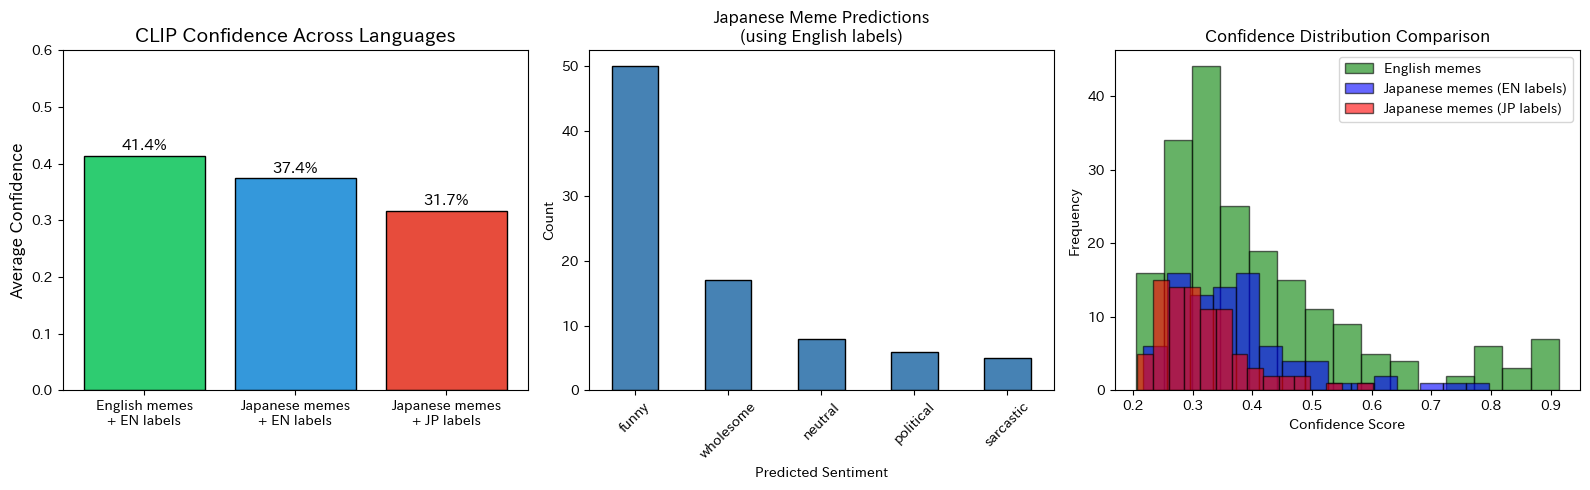

In [26]:
# ============================================================
# SECTION 4: VISUALIZATIONS & ERROR ANALYSIS
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('figures', exist_ok=True)

# ============================================================
# 4.1: Cross-Lingual Comparison Bar Chart
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Chart 1: Confidence Comparison
ax1 = axes[0]
conditions = ['English memes\n+ EN labels', 'Japanese memes\n+ EN labels', 'Japanese memes\n+ JP labels']
confidences = [
    english_results['confidence'].mean(),
    japanese_results['confidence_en'].mean(),
    japanese_results['confidence_jp'].mean()
]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax1.bar(conditions, confidences, color=colors, edgecolor='black')
ax1.set_ylabel('Average Confidence', fontsize=12)
ax1.set_title('CLIP Confidence Across Languages', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 0.6)

# Add value labels on bars
for bar, conf in zip(bars, confidences):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{conf:.1%}', ha='center', fontsize=11, fontweight='bold')

# Chart 2: Prediction Distribution (Japanese memes)
ax2 = axes[1]
jp_pred_counts = japanese_results['predicted_en'].value_counts()
jp_pred_counts.plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_xlabel('Predicted Sentiment')
ax2.set_ylabel('Count')
ax2.set_title('Japanese Meme Predictions\n(using English labels)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Chart 3: Confidence Distribution Comparison
ax3 = axes[2]
ax3.hist(english_results['confidence'], bins=15, alpha=0.6, label='English memes', color='green', edgecolor='black')
ax3.hist(japanese_results['confidence_en'], bins=15, alpha=0.6, label='Japanese memes (EN labels)', color='blue', edgecolor='black')
ax3.hist(japanese_results['confidence_jp'], bins=15, alpha=0.6, label='Japanese memes (JP labels)', color='red', edgecolor='black')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Confidence Distribution Comparison', fontsize=12)
ax3.legend()

plt.tight_layout()
plt.savefig('figures/cross_lingual_comparison.png', dpi=150, bbox_inches='tight')
print(" Saved: figures/cross_lingual_comparison.png")
plt.show()

In [34]:
# ============================================================
# 4.2: Accuracy Analysis
# ============================================================

print("\n ACCURACY ANALYSIS")
print("="*50)

# Calculate accuracy for Japanese memes - FIXED version
def check_match(row):
    predicted = str(row['predicted_en']).lower()
    actual = str(row['actual_sentiment']).lower()
    return actual in predicted or predicted in actual

japanese_results['correct'] = japanese_results.apply(check_match, axis=1)
accuracy = japanese_results['correct'].mean()

print(f"Japanese meme accuracy (predicted vs annotated): {accuracy:.1%}")

# Confusion-style breakdown
print("\n📋 Prediction vs Actual Sentiment:")
confusion = pd.crosstab(
    japanese_results['actual_sentiment'],
    japanese_results['predicted_en'],
    margins=True
)
print(confusion)


 ACCURACY ANALYSIS
Japanese meme accuracy (predicted vs annotated): 41.9%

📋 Prediction vs Actual Sentiment:
predicted_en      funny  neutral  political  sarcastic  wholesome  All
actual_sentiment                                                      
funny                34        7          2          4         13   60
neutral               2        0          0          0          0    2
offensive             1        0          0          0          0    1
political             1        0          0          0          0    1
sarcastic            10        1          4          0          2   17
wholesome             2        0          0          1          2    5
All                  50        8          6          5         17   86


In [29]:
# ============================================================
# 4.3: Category Analysis
# ============================================================

print("\nPERFORMANCE BY CATEGORY")
print("="*50)

category_stats = japanese_results.groupby('category').agg({
    'confidence_en': ['mean', 'count'],
    'confidence_jp': 'mean'
}).round(3)

category_stats.columns = ['EN_label_conf', 'count', 'JP_label_conf']
category_stats = category_stats.sort_values('count', ascending=False)
print(category_stats.head(15))


PERFORMANCE BY CATEGORY
                    EN_label_conf  count  JP_label_conf
category                                               
anime_demon_slayer          0.313      5          0.291
anime_jjk                   0.393      5          0.296
ai_art                      0.382      4          0.300
politics                    0.505      4          0.314
anime_spy_family            0.505      3          0.447
internet_culture            0.368      3          0.310
cat_meme                    0.427      2          0.498
bokete                      0.279      2          0.280
anime_crossover             0.559      2          0.245
gaming_crossover            0.328      2          0.306
vtuber                      0.335      2          0.276
tv_variety                  0.369      2          0.261
tech_humor                  0.486      2          0.352
photoshop                   0.399      2          0.363
wordplay                    0.369      2          0.362


In [30]:
# ============================================================
# 4.4: Summary Statistics for Paper
# ============================================================

print("\n" + "="*60)
print(" SUMMARY FOR PAPER")
print("="*60)

summary_stats = {
    'english_memes': {
        'n': len(english_results),
        'avg_confidence': english_results['confidence'].mean(),
        'std_confidence': english_results['confidence'].std()
    },
    'japanese_memes_en_labels': {
        'n': len(japanese_results),
        'avg_confidence': japanese_results['confidence_en'].mean(),
        'std_confidence': japanese_results['confidence_en'].std()
    },
    'japanese_memes_jp_labels': {
        'n': len(japanese_results),
        'avg_confidence': japanese_results['confidence_jp'].mean(),
        'std_confidence': japanese_results['confidence_jp'].std()
    },
    'cross_lingual_gap': english_results['confidence'].mean() - japanese_results['confidence_en'].mean(),
    'label_language_gap': japanese_results['confidence_en'].mean() - japanese_results['confidence_jp'].mean()
}

import json
print(json.dumps(summary_stats, indent=2, default=lambda x: f"{x:.4f}" if isinstance(x, float) else x))

# Save summary
with open('results/summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=lambda x: round(x, 4) if isinstance(x, float) else x)
print("\n Summary saved to: results/summary_statistics.json")


 SUMMARY FOR PAPER
{
  "english_memes": {
    "n": 200,
    "avg_confidence": 0.4136845345795155,
    "std_confidence": 0.16771621785259072
  },
  "japanese_memes_en_labels": {
    "n": 86,
    "avg_confidence": 0.37407917286767517,
    "std_confidence": 0.11038938559473437
  },
  "japanese_memes_jp_labels": {
    "n": 86,
    "avg_confidence": 0.31722581681124,
    "std_confidence": 0.07384573336110947
  },
  "cross_lingual_gap": 0.039605361711840315,
  "label_language_gap": 0.056853356056435156
}

 Summary saved to: results/summary_statistics.json


---
## Results Compilation & Paper Preparation

In [31]:
# ============================================================
# SECTION 5: EXPORT ALL RESULTS
# ============================================================

import shutil
import os

# Create paper materials folder
os.makedirs('paper_materials', exist_ok=True)

# Copy all results
files_to_copy = [
    ('figures/cross_lingual_comparison.png', 'paper_materials/'),
    ('figures/english_baseline_results.png', 'paper_materials/'),
    ('results/summary_statistics.json', 'paper_materials/'),
    ('results/english_meme_results.csv', 'paper_materials/'),
    ('results/japanese_meme_results.csv', 'paper_materials/')
]

print("Exporting paper materials...")
for src, dst in files_to_copy:
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"   ✅ {src}")
    else:
        print(f"   ⚠️ Not found: {src}")

# Create zip file
!zip -r cross_lingual_clip_results.zip results/ figures/ paper_materials/ 2>/dev/null

print("\n" + "="*60)
print(" PROJECT COMPLETE!")
print("="*60)

Exporting paper materials...
   ✅ figures/cross_lingual_comparison.png
   ✅ figures/english_baseline_results.png
   ✅ results/summary_statistics.json
   ✅ results/english_meme_results.csv
   ✅ results/japanese_meme_results.csv
  adding: results/ (stored 0%)
  adding: results/summary_statistics.json (deflated 54%)
  adding: results/japanese_meme_results.csv (deflated 66%)
  adding: results/english_meme_results.csv (deflated 57%)
  adding: figures/ (stored 0%)
  adding: figures/english_baseline_results.png (deflated 19%)
  adding: figures/cross_lingual_comparison.png (deflated 17%)
  adding: paper_materials/ (stored 0%)
  adding: paper_materials/english_baseline_results.png (deflated 19%)
  adding: paper_materials/summary_statistics.json (deflated 54%)
  adding: paper_materials/japanese_meme_results.csv (deflated 66%)
  adding: paper_materials/english_meme_results.csv (deflated 57%)
  adding: paper_materials/cross_lingual_comparison.png (deflated 17%)

 PROJECT COMPLETE!


In [35]:
from google.colab import files
files.download('cross_lingual_clip_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>